In [1]:
!pip install q numpy==1.17

In [0]:
import re

import os
from os import listdir
from os.path import isfile, join

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms as transf
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np

from PIL import Image

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj" -O openlogo.tar && rm -rf /tmp/cookies.txt
!tar -xvf openlogo.tar

images_folder = "openlogo/JPEGImages"
annotations_folder = "openlogo/Annotations"
train_query_file = "openlogo/ImageSets/Main/train_test/train_all.txt"
test_query_file = "openlogo/ImageSets/Main/train_test/test_all.txt"

Streaming output truncated to the last 5000 lines.
openlogo/JPEGImages/hondaimg000205.jpg
openlogo/Annotations/apeimg000015.xml
openlogo/Annotations/siemens3.xml
openlogo/JPEGImages/logos32plus_003856.jpg
openlogo/JPEGImages/chanel41.jpg
openlogo/JPEGImages/Belgalogos_07582934.jpg
openlogo/JPEGImages/61839900.jpg
openlogo/Annotations/kraftimg000003.xml
openlogo/JPEGImages/logos32plus_000801.jpg
openlogo/Annotations/logos32plus_003692.xml
openlogo/JPEGImages/essoimg000006.jpg
openlogo/JPEGImages/logos32plus_001952.jpg
openlogo/Annotations/batman5.xml
openlogo/JPEGImages/Hisense_sportslogo_65.jpg
openlogo/Annotations/logos32plus_000073.xml
openlogo/JPEGImages/flickrlogo27_3778060828.jpg
openlogo/Annotations/boschimg000151.xml
openlogo/JPEGImages/aralimg000145.jpg
openlogo/Annotations/prada48.xml
openlogo/JPEGImages/fritolaysimg000043.jpg
openlogo/Annotations/logos32plus_000459.xml
openlogo/Annotations/logos32plus_004264.xml
openlogo/JPEGImages/boeingimg000044.jpg
openlogo/JPEGImages/logo

In [4]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7783 (delta 2), reused 1 (delta 0), pack-reused 7780
Receiving objects: 100% (7783/7783), 10.05 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (5320/5320), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
image_pattern = re.compile(r'^(?P<key>\w+)\.jpg$')
annotation_pattern = re.compile(r'^(?P<key>\w+)\.xml$')

class LogoDetectionDataset(Dataset):
  
  def __init__(self, image_folder, annotation_folder, query_file, transform=None, target_transform=None):
    self.image_folder = image_folder
    self.annotation_folder = annotation_folder
    self.transform = transform
    self.target_transform = target_transform
    self.image_names = self.__get_file_names__(image_folder, image_pattern)
    self.annotation_names = self.__get_file_names__(annotation_folder, annotation_pattern)

    self.keys = sorted(list(set(self.image_names.keys()) & set(self.annotation_names.keys())))
    with open(query_file) as file:
      file_content = file.read()
      self.keys = list(filter(lambda key: key in file_content, self.keys))
  
  def __len__(self):
    return len(self.keys)

  def __getitem__(self, index): 
    key = self.keys[index]

    image_name = self.image_names[key]
    annotation_name = self.annotation_names[key]

    image_path = os.path.join(self.image_folder, image_name)
    annotation_path = os.path.join(self.annotation_folder, annotation_name)

    img = Image.open(image_path).convert('RGB')
    target = self.__get_target__(annotation_path, index)

    if self.transform:
      img = self.transform(img)

    if self.target_transform:
      img, target = self.target_transform(img, target)

    return img, target

  def __get_target__(self, annotation_path, index):
    target = {}
    boxes = []
    root = ET.parse(annotation_path).getroot()
    for bndbox in root.findall('object/bndbox'):
      xmin = int(bndbox[0].text)
      ymin = int(bndbox[1].text)
      xmax = int(bndbox[2].text)
      ymax = int(bndbox[3].text)
      boxes.append((xmin, ymin, xmax, ymax))

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    num_objs = len(boxes)
    labels = torch.ones((num_objs), dtype=torch.int64)
    img_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = img_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    return target

  def __get_file_names__(self, folder, file_name_pattern):
    file_names = {}
    for f in listdir(folder):
      match = file_name_pattern.match(f)
      if not match:
        continue
      
      num = match.group('key')
      if num == '':
        continue
      
      file_names[num] = f

    return file_names

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms

tfs = transf.Compose([
                          transf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                          transf.RandomGrayscale(p=0.1),
                       ])
target_tfs = transforms.Compose([
                                transforms.ToTensor(),
])

target_test_tfs = transforms.Compose([
                               transforms.ToTensor(),     
                       ])

num_classes = 2
batch_size = 4

dataset = LogoDetectionDataset(images_folder, annotations_folder, train_query_file, transform=tfs, target_transform=target_tfs)
test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file, target_transform=target_test_tfs)
orig_test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file)

validation_size = .0

data_size = len(dataset)
test_data_size = len(test_dataset)

split_val = int(np.floor(validation_size * data_size))

indices = list(range(data_size))
test_indices = list(range(test_data_size))
np.random.seed(42)
np.random.shuffle(indices)
np.random.shuffle(test_indices)
val_indices, train_indices = indices[:split_val], indices[split_val:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=val_sampler, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          sampler=test_sampler, collate_fn=utils.collate_fn)

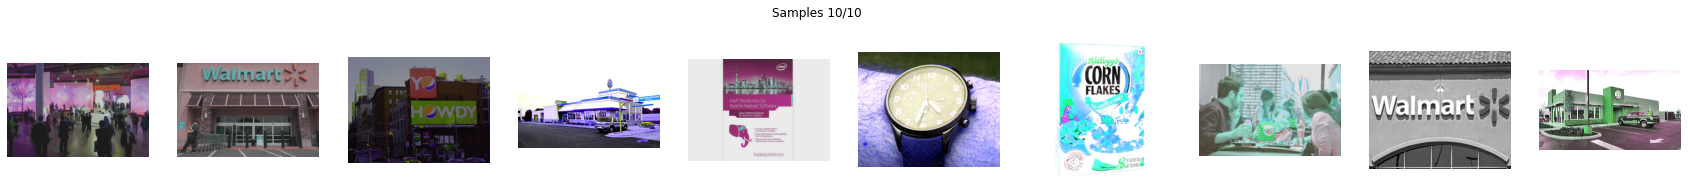

In [8]:
def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        image, _ = dataset[index]
        plt.subplot(1, count, i+1)
        plt.imshow(image)
        plt.grid(False)
        plt.axis('off')   
    
show_dataset = LogoDetectionDataset(images_folder, annotations_folder, train_query_file, transform=transf.Compose([
                          transf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                          transf.RandomGrayscale(p=0.1),   
]))
indices = np.random.choice(np.arange(len(show_dataset)), 10, replace=False)

visualize_samples(show_dataset, indices, "Samples")

In [9]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
model = torch.load("drive/My Drive/save/save-aug-2")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [9]:
last_saved_epoch = 3
num_epochs = 5

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, last_saved_epoch + epoch, print_freq=1000)
  lr_scheduler.step()
  torch.save(model, "drive/My Drive/save/save-aug-" + str(last_saved_epoch + epoch))
  #evaluate(model, val_loader, device=device)

torch.save(model, "drive/My Drive/save/save-aug-complete")

Epoch: [3]  [   0/4634]  eta: 4:12:38  lr: 0.000500  loss: 0.1984 (0.1984)  loss_classifier: 0.0953 (0.0953)  loss_box_reg: 0.0831 (0.0831)  loss_objectness: 0.0064 (0.0064)  loss_rpn_box_reg: 0.0136 (0.0136)  time: 3.2711  data: 1.0180  max mem: 7345
Epoch: [3]  [1000/4634]  eta: 1:15:53  lr: 0.000500  loss: 0.0939 (0.1187)  loss_classifier: 0.0650 (0.0644)  loss_box_reg: 0.0209 (0.0280)  loss_objectness: 0.0064 (0.0118)  loss_rpn_box_reg: 0.0071 (0.0145)  time: 1.2753  data: 0.4272  max mem: 8465
Epoch: [3]  [2000/4634]  eta: 0:54:22  lr: 0.000500  loss: 0.0877 (0.1222)  loss_classifier: 0.0472 (0.0662)  loss_box_reg: 0.0246 (0.0290)  loss_objectness: 0.0044 (0.0119)  loss_rpn_box_reg: 0.0085 (0.0150)  time: 1.2050  data: 0.4200  max mem: 8465
Epoch: [3]  [3000/4634]  eta: 0:33:48  lr: 0.000500  loss: 0.1184 (0.1222)  loss_classifier: 0.0616 (0.0660)  loss_box_reg: 0.0285 (0.0291)  loss_objectness: 0.0080 (0.0119)  loss_rpn_box_reg: 0.0102 (0.0151)  time: 1.2735  data: 0.4678  max me

In [8]:
model = torch.load("drive/My Drive/save/save-aug-complete")
model.to(device)
evaluate(model, test_loader, device=device)

creating index...
index created!
Test:  [   0/8322]  eta: 1:32:23  model_time: 0.6257 (0.6257)  evaluator_time: 0.0102 (0.0102)  time: 0.6661  data: 0.0223  max mem: 505
Test:  [ 100/8322]  eta: 0:23:16  model_time: 0.1454 (0.1476)  evaluator_time: 0.0029 (0.0032)  time: 0.1613  data: 0.0127  max mem: 616
Test:  [ 200/8322]  eta: 0:22:46  model_time: 0.1377 (0.1437)  evaluator_time: 0.0027 (0.0034)  time: 0.1649  data: 0.0214  max mem: 674
Test:  [ 300/8322]  eta: 0:22:11  model_time: 0.1381 (0.1422)  evaluator_time: 0.0032 (0.0034)  time: 0.1552  data: 0.0148  max mem: 674
Test:  [ 400/8322]  eta: 0:22:09  model_time: 0.1470 (0.1421)  evaluator_time: 0.0028 (0.0034)  time: 0.1623  data: 0.0139  max mem: 742
Test:  [ 500/8322]  eta: 0:21:42  model_time: 0.1461 (0.1418)  evaluator_time: 0.0027 (0.0033)  time: 0.1615  data: 0.0142  max mem: 742
Test:  [ 600/8322]  eta: 0:21:29  model_time: 0.1440 (0.1419)  evaluator_time: 0.0027 (0.0033)  time: 0.1596  data: 0.0141  max mem: 742
Test:  [

In [0]:
model = torch.load("drive/My Drive/save/save-hiper-complete")

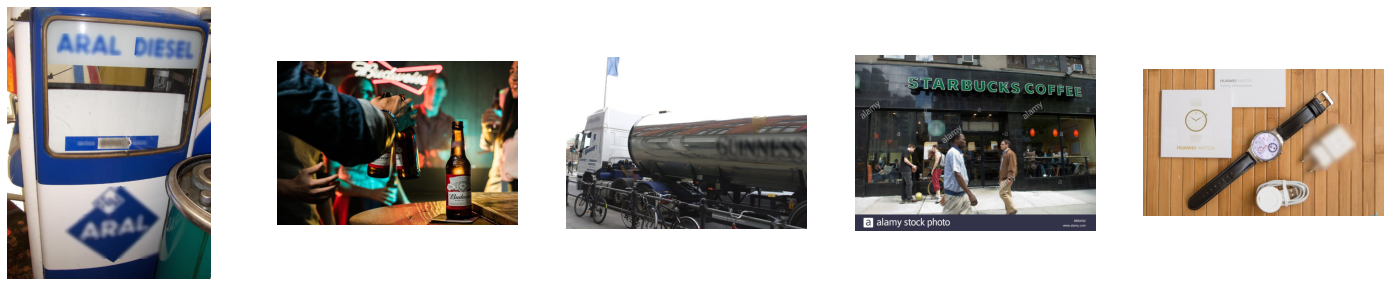

In [12]:
from PIL import ImageFilter

score_filter = 0.5

model.eval()
count = 5
plt.figure(figsize=(count * 5,5))
for i_step, (images, targets) in enumerate(test_loader):
  if i_step == count:
    break
    
  test_image = list(image.to(device) for image in images)
  prediction = model(test_image)[0]

  image_id = int(targets[0]['image_id'])
  image, target = orig_test_dataset[image_id]

  boxes = target['boxes']
  predict_boxes = prediction['boxes']
  predict_labels = prediction['labels']
  predict_scores = prediction['scores']

  plt.subplot(1, count, i_step + 1)

  #for box in boxes:
    #x = [box[0], box[2]]
    #y = [box[1], box[3]]
    #plt.plot(x, y, marker = 'o', label='Correct')
  for i, box in enumerate(predict_boxes):
    if predict_scores[i] < score_filter:
      continue
    ib = (int(box[0]), int(box[1]), int(box[2]), int(box[3]))
    ic = image.crop(ib)
    for i in range(20):
      ic = ic.filter(ImageFilter.GaussianBlur())
    image.paste(ic, ib)
    #x = [box[0], box[2]]
    #y = [box[1], box[3]]
    #predict_label = int(predict_labels[i])
    #view_label = 'Box - %d Label - %d' % (i, predict_label)
    #plt.plot(x, y, marker = 'o', label=view_label)

  plt.imshow(image)

  plt.grid(False)
  plt.axis('off')
  #plt.legend()  